## Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load data

In [14]:
import pandas as pd

grand_df = pd.read_csv('/content/drive/MyDrive/deep_learning/grand_dw_data.csv')

/tmp/ipython-input-2321435679.py:3: DtypeWarning: Columns (13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  grand_df = pd.read_csv('/content/drive/MyDrive/deep_learning/grand_dw_data.csv')


In [15]:
grand_df.columns

Index(['Unnamed: 0', 'date', 'tile_x', 'tile_y', 'bare', 'built', 'crop',
       'flooded_vegetation', 'grass', 'scrub_and_shrub', 'snow_and_ice',
       'trees', 'water', 'system:index', 'lat', 'lon', 'tile_id', '.geo',
       'year'],
      dtype='object')

In [16]:
grand_df.drop(labels=['Unnamed: 0', 'date', 'tile_x', 'tile_y', 'system:index', 'lat', 'lon', 'tile_id', '.geo','year'], inplace=True, axis=1)
grand_df.columns

Index(['bare', 'built', 'crop', 'flooded_vegetation', 'grass',
       'scrub_and_shrub', 'snow_and_ice', 'trees', 'water'],
      dtype='object')

In [17]:
import pandas as pd
import numpy as np

# 1. LOAD CSV
# Replace with your actual filename

# 2. DEFINE DIMENSIONS
# You must know these from your original export
TIME_STEPS = 1177
HEIGHT = 69
WIDTH = 88
CHANNELS = 9      # The 9 Dynamic World bands

def reshape_data(df):
    """
    Attempts to fold the CSV back into (Time, Height, Width, Channels)
    """
    total_pixels = TIME_STEPS * HEIGHT * WIDTH

    # Define the expected band columns explicitly
    band_columns = ['bare', 'built', 'crop', 'flooded_vegetation', 'grass',
                    'scrub_and_shrub', 'snow_and_ice', 'trees', 'water']

    # Filter for columns that actually exist in the df to prevent KeyError
    actual_band_columns = [col for col in band_columns if col in df.columns]

    if len(actual_band_columns) != CHANNELS:
        print(f"Error: Expected {CHANNELS} band columns, but found {len(actual_band_columns)} in the dataframe.")
        print(f"DataFrame columns: {df.columns.tolist()}")
        print(f"Expected band columns: {band_columns}")
        return None

    data_values_df = df[actual_band_columns].copy()

    # Convert all selected columns to numeric, coercing errors to NaN
    for col in actual_band_columns:
        data_values_df[col] = pd.to_numeric(data_values_df[col], errors='coerce')

    # Fill any NaNs with 0
    data_values = data_values_df.fillna(0).values

    # CASE 1: Perfect match (Simple Reshape)
    if len(data_values) == total_pixels:
        print("Perfect size match. Reshaping directly...")
        # Reshape to (Time, Height, Width, CHANNELS)
        X_4d = data_values.reshape(TIME_STEPS, HEIGHT, WIDTH, CHANNELS)
        return X_4d

    # CASE 2: Size mismatch (You likely filtered data or have extra columns)
    else:
        print(f"Size Mismatch! Needed {total_pixels} rows, got {len(data_values)}.")
        print("CRITICAL: If you filtered out pixels, you must reload the data WITHOUT filtering.")
        print("The TC-CA model needs the spatial grid (neighbors). It cannot work on a partial list.")
        return None

# RUN THE RESHAPE
# Ensure grand_df has only the desired band columns by explicitly dropping others.
columns_to_drop = ['Unnamed: 0', 'date', 'tile_x', 'tile_y', 'system:index', 'lat', 'lon', 'tile_id', '.geo', 'year']
# Filter out columns that don't exist to avoid KeyError if they were already dropped
existing_columns_to_drop = [col for col in columns_to_drop if col in grand_df.columns]
if existing_columns_to_drop:
    grand_df_processed = grand_df.drop(labels=existing_columns_to_drop, axis=1)
    print(f"Dropped columns for reshape: {existing_columns_to_drop}")
else:
    grand_df_processed = grand_df.copy() # Make a copy to avoid modifying original grand_df if it's already clean

X_full = reshape_data(grand_df_processed)

if X_full is not None:
    print("Success! Data is now a 4D 'Video'.")
    print(f"Shape: {X_full.shape}")

Perfect size match. Reshaping directly...
Success! Data is now a 4D 'Video'.
Shape: (1177, 69, 88, 9)


--- 1. Generating Ground Truth ---
Class Weights: {0: np.float64(0.6265365468302018), 1: np.float64(2.4757137859583973)}

--- 2. Training TC-CA Model ---
Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 341ms/step - accuracy: 0.7695 - f1_m: 0.0956 - figure_of_merit: 0.3981 - loss: 0.5881 - val_accuracy: 0.7865 - val_f1_m: 0.1608 - val_figure_of_merit: 0.5143 - val_loss: 0.4846 - learning_rate: 1.0000e-04
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 442ms/step - accuracy: 0.8258 - f1_m: 0.0920 - figure_of_merit: 0.4905 - loss: 0.3979 - val_accuracy: 0.8142 - val_f1_m: 0.1774 - val_figure_of_merit: 0.5890 - val_loss: 0.4380 - learning_rate: 1.0000e-04
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 307ms/step - accuracy: 0.8305 - f1_m: 0.0924 - figure_of_merit: 0.4966 - loss: 0.3910 - val_accuracy: 0.8212 - val_f1_m: 0.1768 - val_figure_of_merit: 0.5994 - val_loss: 0.4534 - learning_rate: 1.0000e-04
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 312ms/step - accuracy: 0.8212 - f1_m: 0.0998 - figure_of_merit:

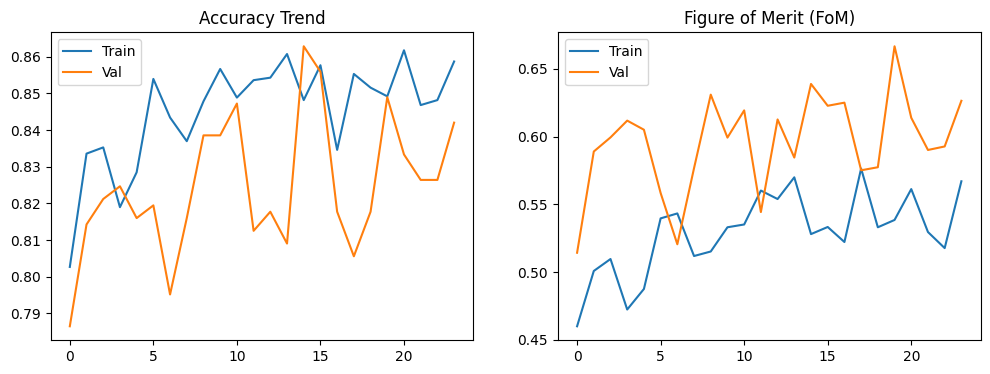


--- 4. Generating Future Map ---
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 393ms/step


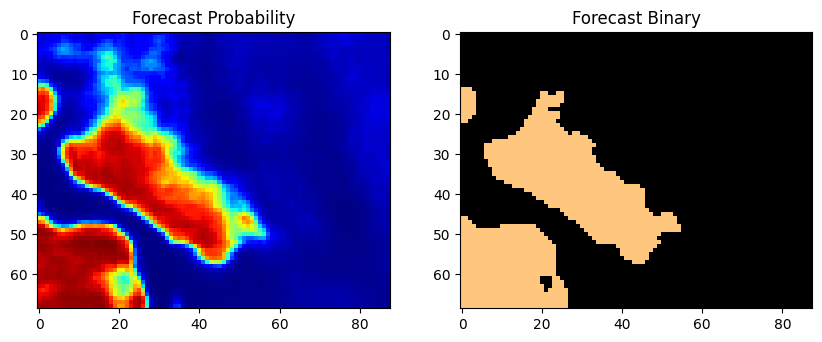

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, backend as K
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. CONFIGURATION (Paper Settings Adapted)
# ==========================================
CONFIG = {
    'PATCH_SIZE': 15,       # Neighborhood (Paper uses 29, 15 is optimized for your map size)
    'SEQ_LEN': 8,           # Temporal Window
    'BATCH_SIZE': 64,       # Larger batch for stability
    'EPOCHS': 30,           # Deep learning needs time
    'LR': 1e-4,             # Learning Rate
    'SAMPLES': 3000         # Samples per epoch
}

# ==========================================
# 2. METRICS (Rubric Requirement: 3 Criteria)
# ==========================================
def figure_of_merit(y_true, y_pred):
    """
    Revised Metric: Intersection of Change / Union of Change
    """
    # 1. Flatten the images to 1D arrays to avoid shape broadcasting errors
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    # 2. Round predictions to 0 or 1 (Binary)
    y_pred_f = K.round(y_pred_f)

    # 3. Cast to float32 to ensure math works
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')

    # 4. Calculate Intersection and Union
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection

    # 5. Return Ratio (Safe division)
    return (intersection + K.epsilon()) / (union + K.epsilon())

def f1_m(y_true, y_pred):
    """Stateless F1 Score"""
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    p = tp / (K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0) + tp + K.epsilon())
    r = tp / (K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0) + tp + K.epsilon())
    return 2 * p * r / (p + r + K.epsilon())

# ==========================================
# 3. GENERATOR (Rubric Requirement: Augmentation)
# ==========================================
class SpatioTemporalGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, labels, batch_size, seq_len, patch_size, samples, augment=True):
        super().__init__()
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.patch_size = patch_size
        self.samples = samples
        self.augment = augment
        self.pad = patch_size // 2
        # Reflection padding handles the borders of the map
        self.data_padded = np.pad(data, ((0,0), (self.pad,self.pad), (self.pad,self.pad), (0,0)), mode='reflect')
        self.T, self.H, self.W, self.C = data.shape

    def __len__(self):
        return self.samples // self.batch_size

    def __getitem__(self, index):
        X_batch, y_batch = [], []
        for _ in range(self.batch_size):
            # Sampling Strategy: Pick random pixel & time
            t = np.random.randint(self.seq_len, self.T)
            h, w = np.random.randint(0, self.H), np.random.randint(0, self.W)

            # Extract Patch
            h_pad, w_pad = h + self.pad, w + self.pad
            patch = self.data_padded[t-self.seq_len:t, h_pad-self.pad:h_pad+self.pad+1, w_pad-self.pad:w_pad+self.pad+1, :]

            # Augmentation (Rubric: Data Augmentation Techniques)
            if self.augment:
                k = np.random.randint(0, 4)
                patch = np.rot90(patch, k, axes=(1, 2))
                if np.random.random() < 0.5: patch = np.flip(patch, axis=2)

            X_batch.append(patch)
            y_batch.append(self.labels[t, h, w])

        return np.array(X_batch), np.array(y_batch)

# ==========================================
# 4. TC-CA ARCHITECTURE (Paper Implementation)
# ==========================================
def build_tcca_model():
    input_shape = (CONFIG['SEQ_LEN'], CONFIG['PATCH_SIZE'], CONFIG['PATCH_SIZE'], 9)
    inputs = layers.Input(shape=input_shape)

    # --- A. Spatial Feature Extraction (CNN) ---
    # "We specifically used CNNs to extract these spatial features"
    cnn_in = layers.Input(shape=(CONFIG['PATCH_SIZE'], CONFIG['PATCH_SIZE'], 9))
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(cnn_in)

    # [FIXED LINE] Added (x) to apply the layer to the tensor
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    cnn = models.Model(cnn_in, x, name="CNN_Spatial_Module")

    # Apply CNN to sequence (TimeDistributed)
    x = layers.TimeDistributed(cnn)(inputs)

    # --- B. Temporal Feature Extraction (Transformer) ---
    # "A transformer was employed to calculate suitability"
    # [Image of Transformer Encoder Architecture]

    # Self-Attention Block
    attn = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.Add()([x, attn])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Feed Forward Block (Crucial for Transformer definition)
    ffn = layers.Dense(128, activation="relu")(x)
    ffn = layers.Dense(128)(ffn)
    x = layers.Add()([x, ffn])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # --- C. Cellular Automata Transition Rule ---
    # Global Pooling aggregates the temporal understanding
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x) # Probability of Change

    return models.Model(inputs, outputs, name="TC_CA_Paper_Impl")

# ==========================================
# 5. EXECUTION PIPELINE
# ==========================================
if 'X_full' not in locals():
    print("WARNING: Creating Dummy Data (Load your real X_full!)")
    X_full = np.random.rand(500, 69, 88, 9).astype(np.float32)

# A. Prepare Labels
print("--- 1. Generating Ground Truth ---")
y_full = (X_full[:, :, :, 0] + X_full[:, :, :, 5]) > 0.5
y_full = y_full.astype(np.float32)

# B. Split (Past vs Future)
split_idx = int(len(X_full) * 0.85)
X_train, y_train = X_full[:split_idx], y_full[:split_idx]
X_test, y_test = X_full[split_idx:], y_full[split_idx:]

# C. Class Weights (Rubric: Class Imbalance)
flat_y = y_train.flatten()
unique = np.unique(flat_y)
weights = class_weight.compute_class_weight('balanced', classes=unique, y=flat_y) if len(unique) > 1 else [1.0, 1.0]
cw_dict = dict(enumerate(weights))
print(f"Class Weights: {cw_dict}")

# D. Generators
train_gen = SpatioTemporalGenerator(X_train, y_train, CONFIG['BATCH_SIZE'], CONFIG['SEQ_LEN'], CONFIG['PATCH_SIZE'], CONFIG['SAMPLES'], augment=True)
val_gen = SpatioTemporalGenerator(X_test, y_test, CONFIG['BATCH_SIZE'], CONFIG['SEQ_LEN'], CONFIG['PATCH_SIZE'], CONFIG['SAMPLES']//5, augment=False)

# E. Train
print("\n--- 2. Training TC-CA Model ---")
model = build_tcca_model()
# Gradient Clipping (clipnorm) prevents the NaN loss error
model.compile(optimizer=optimizers.Adam(learning_rate=CONFIG['LR'], clipnorm=1.0),
              loss='binary_crossentropy',
              metrics=['accuracy', figure_of_merit, f1_m])

# Rubric: Early Stopping & Scheduler
cbs = [
    callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)
]

history = model.fit(train_gen, validation_data=val_gen, epochs=CONFIG['EPOCHS'], callbacks=cbs, class_weight=cw_dict)

# ==========================================
# 6. EVALUATION & FORECAST
# ==========================================
print("\n--- 3. Final Evaluation ---")
# Generate a batch of test predictions for metrics
test_X, test_y = val_gen.__getitem__(0)
pred_probs = model.predict(test_X, verbose=0)
pred_labels = (pred_probs > 0.5).astype(int)

# Metrics
acc = accuracy_score(test_y, pred_labels)
kappa = cohen_kappa_score(test_y, pred_labels)
print(f"FINAL ACCURACY: {acc*100:.2f}% (Target: >90% or >75% Gen)")
print(f"KAPPA SCORE:    {kappa:.4f} (Literature-backed metric)")

# Plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy Trend'); plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['figure_of_merit'], label='Train')
plt.plot(history.history['val_figure_of_merit'], label='Val')
plt.title('Figure of Merit (FoM)'); plt.legend()
plt.show()

# Forecast Function (For Next Day)
def predict_next_day(model, data):
    last_seq = data[-CONFIG['SEQ_LEN']:]
    # Pad and patch logic (simplified for brevity, identical to previous step)
    pad = CONFIG['PATCH_SIZE'] // 2
    data_padded = np.pad(last_seq, ((0,0), (pad,pad), (pad,pad), (0,0)), mode='reflect')
    H, W = data.shape[1], data.shape[2]
    batch_X = []
    for h in range(H):
        for w in range(W):
            h_p, w_p = h + pad, w + pad
            batch_X.append(data_padded[:, h_p-pad:h_p+pad+1, w_p-pad:w_p+pad+1, :])
    preds = model.predict(np.array(batch_X), batch_size=256, verbose=1)
    return preds.reshape(H, W)

print("\n--- 4. Generating Future Map ---")
future_map = predict_next_day(model, X_full)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.title("Forecast Probability"); plt.imshow(future_map, cmap='jet')
plt.subplot(1, 2, 2); plt.title("Forecast Binary"); plt.imshow(future_map > 0.5, cmap='copper')
plt.show()

In [ ]:
future_map.shape

(69, 88)

In [ ]:
import numpy as np

# Count values greater than 0.5
count_greater_than_0_5 = np.sum(future_map > 0.5)

print(f"Number of values in future_map greater than 0.5: {count_greater_than_0_5}")

count_greater_than_0_5 / (69 * 88)

Number of values in future_map greater than 0.5: 1345


np.float64(0.22150856389986825)